<a href="https://colab.research.google.com/github/joblazek/psp-auction/blob/main/Algorithm1_async.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   Seller 1                  Seller 2                 
      Buyer     Q_i      P_i    Buyer     Q_i      P_i
0         0   9.179   28.475       10  45.265   95.216
1         1  33.194  102.047       11   1.510    3.216
2         2  49.731   84.236       12   3.952    9.061
3         3  34.819  120.793       13  15.423   19.868
4         4  38.749   40.432       14   1.335    3.677
5         5  48.653   68.350       15  16.058   56.034
6         6  31.153   69.800       16   9.015   11.204
7         7   3.615    7.881       17  44.426  120.087
8         8   6.412   17.011       18  10.853   16.615
9         9  48.876  115.866       19  44.619   64.809
10        G  30.000   45.000        G  30.000   45.000
--- Round 1 ---
   Seller 1                                                         Seller 2                                                       
      Buyer        q_i       p_i        a_i          u_i        c_i    Buyer        q_i       p_i        a_i          u_i       c_i
0    

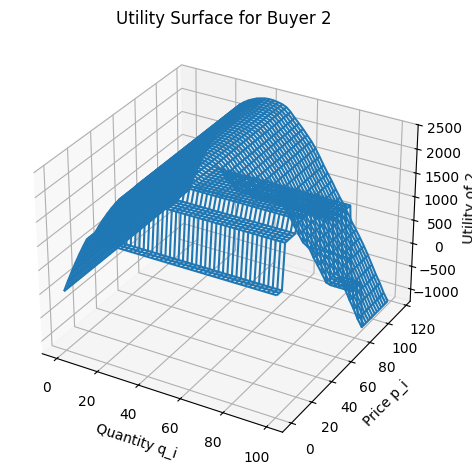

In [11]:
import threading
import time
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, Tuple, List, Optional
from mpl_toolkits.mplot3d import Axes3D

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

class Seller:
    """Holds bids for a PSP auction."""
    def __init__(self, Q_max: float, epsilon: float):
        self.Q_max = Q_max
        self.s: Dict[str, Tuple[float, float]] = {}
        self.epsilon = epsilon
        self.lock = threading.Lock()
        self.listeners: List['buyer'] = []

    def update_bid(self, i: str, s_i: Tuple[float, float]):
        """Update the bid profile s_i = (q_i, p_i) for buyer i; notify all listeners."""
        with self.lock:
            self.s[i] = s_i
            # Notify buyers so they can recompute
            for listener in self.listeners:
                listener.notify_update()

    def register_listener(self, buyer: 'buyer'):
        """buyers call this to receive bid-update notifications."""
        self.listeners.append(buyer)

    def get_s_hat_minus(self, i: str) -> Dict[str, Tuple[float, float]]:
        """Retrieve ŝ_{-i}: bids of all buyers except i."""
        with self.lock:
            return {j: s for j, s in self.s.items() if j != i}

class Buyer:
    """
    Implements Algorithm 1 (Lazar & Semret, Appendix B),
    listens for seller updates.

    Initialization:
        s_i = 0
        ŝ_{-i} = ∅

    1. Compute truthful ε-best reply t_i = (v_i, w_i):
        v_i = [ sup G_i(ŝ_{-i}) – ε / θ_i′(0) ]_+
        w_i = θ_i′(v_i)

        where sup G_i(ŝ_{-i}) is
        sup { z ∈ [0, Q] :
              z ≤ Q_i(θ_i′(z), ŝ_{-i})
           and ∫₀ᶻ P_i(ζ, ŝ_{-i}) dζ ≤ b_i }

    2. If u_i(t_i, ŝ_{-i}) > u_i(s_i, ŝ_{-i}) + ε, then
           s_i ← t_i

    3. Sleep 1 second and repeat.
    """
    def __init__(self, i: str, epsilon: float, b_i: float,
                 q_i: float, kappa_i: float,
                 seller: Seller):
        """
        :param i: buyer id
        :param epsilon: threshold ε
        :param b_i: budget
        :param q_i: max physical quantity
        :param kappa_i: valuation intensity
        :param seller: the seller this buyer bids on
        """
        self.i = i
        self.epsilon = epsilon  # convergence threshold
        self.b_i = b_i          # budget constraint
        self.q_i = q_i          # capacity (max quantity)
        self.kappa_i = kappa_i  # valuation intensity
        self.seller = seller

        # Current bid (q_i, p_i)
        self.s_i: Tuple[float,float] = (0.0, 0.0)
        self.seller.update_bid(self.i, self.s_i)

        # Concurrency primitives
        self.update_event = threading.Event()
        self.running = True

        # Register for updates
        self.seller.register_listener(self)

    def notify_update(self):
        """Called by seller when any bid updates."""
        self.update_event.set()

    def theta_i(self, z: float) -> float:
        """Valuation θ_i(z), θ(z) = κ * q_i * m - (κ/2) * m^2."""
        m = min(z, self.q_i)
        return self.kappa_i * self.q_i * m - 0.5 * self.kappa_i * m**2

    def theta_i_prime(self, z: float) -> float:
        """Marginal valuation θ'_i(z) = κ * (q_i - z) for z ≤ q_i."""
        if z < self.q_i:
            return self.kappa_i * (self.q_i - z)
        else:
            return 0.0

    def Q_i(self, p_i: float, s_hat_minus: Dict[str, Tuple[float, float]]) -> float:
        """
            Q̄_i(p_i; s_{-i}) = max { Q_max - ∑_{j: p_j > p_i} q_j, 0 }
            where each opponent j requests quantity q_j at price p_j.
            Returns the maximum quantity available to you after fully
            serving all opponents whose bids strictly exceed p_i.
        """
        rem = self.seller.Q_max
        for qj, pj in s_hat_minus.values():
            if pj > p_i:
                rem -= qj
        return max(rem, 0.0)

    def Q_i_bar(self, p_i: float, s_hat_minus: Dict[str, Tuple[float, float]]) -> float:
        """Supply excluding bids ≥ p_i."""
        rem = self.seller.Q_max
        for qj, pj in s_hat_minus.values():
            if pj >= p_i:
                rem -= qj
        return max(rem, 0.0)

    def P_i(self, z: float, s_hat_minus: Dict[str, Tuple[float, float]]) -> float:
        """
            P_i(z; ŝ_{-i}) = inf { y ≥ 0 : Q_i(y; ŝ_{-i}) ≥ z }.
            Return the smallest y meeting Q_i(y) ≥ z.
        """
        candidates = sorted({0.0} | {pj for (_, pj) in s_hat_minus.values()})
        for y in candidates:
            if self.Q_i(y, s_hat_minus) >= z:
                return y
        return float('inf')

    def integral_P(self, z: float, s_hat_minus: Dict[str, Tuple[float, float]]) -> float:
        """Compute ∫₀ᶻ P_i(ζ, ŝ_{-i}) dζ via simple trapezoidal rule.
                where:
          - z = allocation to i under PSP (infinitely divisible),
          - P_i(z; ŝ_{-i}) = inf{y ≥ 0 : Q_i(y; ŝ_{-i}) ≥ z}.
        """
        N = 100
        zs = np.linspace(0, z, N+1)
        Ps = [self.P_i(z_k, s_hat_minus) for z_k in zs]
        dz = z / N if N > 0 else 0
        return sum((Ps[k] + Ps[k+1]) * 0.5 for k in range(N)) * dz

    def a_i(self, s_i: Tuple[float, float], s_hat_minus: Dict[str, Tuple[float, float]]) -> float:
        """
            a_i(s) = q_i ∧ Q_i(p_i, ŝ_{-i})
        """
        q_i, p_i = s_i
        return min(q_i, self.Q_i_bar(p_i, s_hat_minus))

    def c_i(self, s_i: Tuple[float, float], s_hat_minus: Dict[str, Tuple[float, float]]) -> float:
        """
            c_i(s) = ∫₀^{a_i(s)} P_i(z; ŝ_{-i}) dz
        where:
          - a_i(s) = allocation to i under PSP (infinitely divisible),
          - P_i(z; ŝ_{-i}) = inf{y ≥ 0 : Q_i(y; ŝ_{-i}) ≥ z}.
        """
        a = self.a_i(s_i, s_hat_minus)
        return self.integral_P(a, s_hat_minus)

    def u_i(self, s_i: Tuple[float, float], s_hat_minus: Dict[str, Tuple[float, float]]) -> float:
        """
            u_i(s) = θ_i(a_i(s)) − c_i(s)
        """
        a = self.a_i(s_i, s_hat_minus)
        return self.theta_i(a) - self.c_i(s_i, s_hat_minus)

    def sup_G_i(self, s_hat_minus: Dict[str, Tuple[float, float]]) -> float:
        """
            G_i(s_{-i}) = { z ∈ [0, Q_max] :
                z ≤ Q_i(θ'(z); s_{-i}) and ∫₀ᶻ P_i(ζ; s_{-i}) dζ ≤ b_i }
        """
        low, high = 0.0, self.q_i
        for _ in range(20):
            mid = 0.5 * (low + high)
            w = self.theta_i_prime(mid)
            cond1 = (mid <= self.Q_i(w, s_hat_minus))
            cond2 = (self.integral_P(mid, s_hat_minus) <= self.b_i)
            if cond1 and cond2:
                low = mid
            else:
                high = mid
        return low

    def compute_t_i(self, s_hat_minus: Dict[str, Tuple[float, float]]) -> Tuple[float, float]:
        """
        Compute t_i = (v_i, w_i) per Proposition 1:
            v_i = [sup_G - ε/θ_i′(0)]_+
            w_i = θ_i′(v_i)
        """
        Gsup = self.sup_G_i(s_hat_minus)
        base = self.theta_i_prime(0.0)             # = κ_i * q_i > 0
        adj  = self.seller.epsilon / base          # use market’s ε
        v    = max(Gsup - adj, 0.0)                # the v_i update
        w    = self.theta_i_prime(v)               # even if v==0, J
        return v, w

    def step(self) -> bool:
        """One Algorithm 1 iteration; return True if s_i updated."""
        s_hat = self.seller.get_s_hat_minus(self.i)
        old = self.s_i
        t = self.compute_t_i(s_hat)
        u_old = self.u_i(old, s_hat)
        u_new = self.u_i(t, s_hat)
        if u_new > u_old + self.seller.epsilon:
            self.s_i = t
            self.seller.update_bid(self.i, t)
            return True
        return False

    def run(self, interval: float = 1.0):
        """
        Buyer thread: waits for updates or interval timeout, then steps.
        """
        while self.running:
            # Wait until either notified or interval elapsed
            self.update_event.wait(timeout=interval)
            self.update_event.clear()
            self.step()

    def stop(self):
        self.running = False
        self.update_event.set()

    def plot_utility_surface(self,
                             s_hat_minus: Dict[str, Tuple[float, float]],
                             q_steps: int = 50,
                             p_steps: int = 50) -> None:
        """
        Plot the 3D utility surface u_i(z, w) over (quantity z, price w).
        """
        zs = np.linspace(0, self.seller.Q_max, q_steps)
        w_max = self.theta_i_prime(0.0)
        ws = np.linspace(0, w_max, p_steps)
        Z, W = np.meshgrid(zs, ws)
        U = np.zeros_like(Z)
        for i in range(p_steps):
            for j in range(q_steps):
                z_val, w_val = Z[i, j], W[i, j]
                U[i, j] = self.u_i((z_val, w_val), s_hat_minus)
        min_u, max_u = U.min(), U.max()
        print(f"Utility range for buyer {self.i}: {min_u:.2f} to {max_u:.2f}")
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_wireframe(Z, W, U, rstride=1, cstride=1)
        ax.set_xlabel('Quantity q_i')
        ax.set_ylabel('Price p_i')
        ax.set_zlabel(f'Utility of {self.i}')
        plt.title(f'Utility Surface for Buyer {self.i}')
        plt.tight_layout()
        plt.show()

    def plot_valuation(self, num_points: int = 100) -> None:
        zs = np.linspace(0, self.q_i, num_points)
        vals = [self.theta_i(z) for z in zs]
        plt.plot(zs, vals, label=f'Buyer {self.i}')

class GlobalBuyer(Buyer):
    """
    A buyer participating in multiple PSP auctions under a single global budget B_i.

    Joint feasible set:
        G_i^{joint} = { z ∈ ℝ^L₊ : for all j, 0 ≤ z_j ≤ Q_i^{(j)}(p_j; s_{-i}^{(j)}),
                        and ∑_{j=1}^L ∫₀^{z_j} P_i^{(j)}(ζ; s_{-i}^{(j)}) dζ ≤ B_i }

    The joint best-response solves:
        maximize_{z∈G_i^{joint}} ∑_{j=1}^L [ θ_i(z_j) − ∫₀^{z_j} P_i^{(j)}(ζ) dζ ]

    via Lagrangian dual:
        L(z, λ) = ∑_{j=1}^L [ θ_i(z_j) − ∫₀^{z_j} P_i^{(j)}(ζ) dζ ]
                  − λ ( ∑_{j=1}^L ∫₀^{z_j} P_i^{(j)}(ζ) dζ − B_i )
    """
    def __init__(self, i: str, epsilon: float, B_i: float,
                 sellers: List[Seller],
                 q_i: float, kappa_i: float):
        super().__init__(i, epsilon, B_i, q_i, kappa_i, sellers[0])
        self.sellers = sellers
        self.B_i = B_i
        # register with all sellers
        for s in sellers:
            s.register_listener(self)

    def sup_G_single(self,
                     seller: Seller,
                     s_hat_minus: Dict[str, Tuple[float, float]],
                     lam: float) -> float:
        """
        Single-market sup G with Lagrange multiplier λ:
        Find z∈[0,q_i] maximizing θ_i(z) - (1+λ)·c_i(z) per market.
        Solved via binary search on z such that θ_i'(z) ≈ (1+λ)·P_i(z).
        """
        low, high = 0.0, self.q_i
        for _ in range(20):
            mid = 0.5 * (low + high)
            price = self.theta_i_prime(mid)
            # effective marginal cost = (1+lam) * P_i(mid)
            #p_cost = (1+lam) * seller.P_i(mid, s_hat_minus) if hasattr(seller, 'P_i') else (1+lam) * self.P_i(mid, s_hat_minus) NOTE: seller does not have P_i (yet)
            p_cost = (1+lam) * self.P_i(mid, s_hat_minus)
            if price > p_cost:
                low = mid
            else:
                high = mid
        return low

    def compute_t_i_global(self) -> Dict[Seller, Tuple[float, float]]:
        """
        Joint best-response across all sellers under budget B_i.

        Solved by Lagrangian dual: find λ≥0 such that total cost == B_i.
        """
        # collect opponents per seller
        opps = {s: s.get_s_hat_minus(self.i) for s in self.sellers}
        lam_lo, lam_hi = 0.0, 1000.0
        best = {s: (0.0, 0.0) for s in self.sellers}
        # bisection on λ
        for _ in range(30):
            lam = 0.5 * (lam_lo + lam_hi)
            total_cost = 0.0
            bids = {}
            for s in self.sellers:
                z = self.sup_G_single(s, opps[s], lam)
                w = self.theta_i_prime(z)
                bids[s] = (z, w)
                total_cost += self.c_i((z, w), opps[s])
            if total_cost > self.B_i:
                lam_lo = lam
            else:
                lam_hi = lam
                best = bids
        return best

# Helper: generate N buyers with random parameters

def init_buyers(num_buyers: int,
                start: int,
                seller: Seller,
                budget_range: Tuple[float, float] = (5.0, 20.0),
                q_range: Tuple[float, float] = (1.0, 50.0),
                kappa_range: Tuple[float, float] = (1.0, 3.5),
                epsilon: float = 0.1) -> List[Buyer]:
    """
    Create `num_buyers` instances with random b_i, q_i, kappa_i,
    uniform over provided ranges, all with the same epsilon.
    """
    buyers: List[Buyer] = []
    for idx in range(start, start+num_buyers):
        b_i = random.uniform(*budget_range)
        q_i = random.uniform(*q_range)
        kappa_i = random.uniform(*kappa_range)
        label = f"{idx}"
        buyer = Buyer(label, epsilon, b_i, q_i, kappa_i, seller)
        buyers.append(buyer)
    return buyers

# Helpers: save/load buyer parameters for reproducibility

def save_buyers(buyers: List[Buyer], filepath: str) -> None:
    specs = [
        {"id": b.i, "epsilon": b.epsilon,
         "budget": b.b_i, "capacity": b.q_i,
         "kappa": b.kappa_i}
        for b in buyers
    ]
    pd.DataFrame(specs).to_csv(filepath, index=False)

def load_buyers(filepath: str, seller: Seller) -> List[Buyer]:
    df = pd.read_csv(filepath)
    buyers: List[Buyer] = []
    for _, row in df.iterrows():
        buyer = Buyer(
            row["id"], row["epsilon"], row["budget"],
            row["capacity"], row["kappa"], seller
        )
        buyers.append(buyer)
    return buyers

# Initialization helper

def randbids(buyers: List[Buyer], seller: Seller) -> None:
    """Randomly initialize bids: q_i ~ U[0, q_i], p_i = θ_i'(q_i)."""
    for b in buyers:
        q = random.uniform(1.0, b.q_i)
        p = b.theta_i_prime(q)
        b.s_i = (q, p)
        seller.update_bid(b.i, b.s_i)

# Round printing and simulation

def print_round_multi(buyers_by_seller: Dict[Seller, List[Buyer]]) -> None:
    """Display each seller’s round table side-by-side."""
    dfs = []
    for idx, (seller, buyers) in enumerate(buyers_by_seller.items(), start=1):
        df = pd.DataFrame([
            {"Buyer": b.i,
             "q_i": b.s_i[0],
             "p_i": b.s_i[1],
             "a_i": b.a_i(b.s_i, seller.get_s_hat_minus(b.i)),
             "u_i": b.u_i(b.s_i, seller.get_s_hat_minus(b.i)),
             "c_i": b.c_i(b.s_i, seller.get_s_hat_minus(b.i))}
            for b in buyers
        ])
        # label columns by seller index
        df.columns = pd.MultiIndex.from_product([[f"Seller {idx}"], df.columns])
        dfs.append(df)
    combined = pd.concat(dfs, axis=1)
    print(combined)

def print_buyers_multi(buyers_by_seller: Dict[Seller, List[Buyer]]) -> None:
    """Print buyers' Q_i and P_i side-by-side for multiple sellers."""
    dfs = []
    for idx, (seller, buyers) in enumerate(buyers_by_seller.items(), start=1):
        df = pd.DataFrame([
            {"Buyer": b.i,
             "Q_i": b.q_i,
             "P_i": b.theta_i_prime(0.0)}
            for b in buyers
        ])
        df.columns = pd.MultiIndex.from_product([[f"Seller {idx}"], df.columns])
        dfs.append(df)
    combined = pd.concat(dfs, axis=1)
    print(combined.round(3))

# Market totals helper
def market_totals(buyers: List[Buyer], seller: Seller) -> Tuple[float, float, float]:
    """Compute and print total allocation, total valuation, and total utility of the market."""
    total_alloc = 0.0
    total_value = 0.0
    total_utility = 0.0
    for b in buyers:
        s_hat = seller.get_s_hat_minus(b.i)
        a = b.a_i(b.s_i, s_hat)
        total_alloc += a
        total_value += b.theta_i(a)
        total_utility += b.u_i(b.s_i, s_hat)
    print(f"Market Totals -> TotalAlloc: {total_alloc:.2f}, TotalValue: {total_value:.2f}, TotalUtility: {total_utility:.2f}")

def run_simulation(buyers_by_seller, max_rounds=10, delay=1.0):
    sellers = list(buyers_by_seller.keys())
    # collect each unique buyer exactly once
    all_buyers = []
    for blist in buyers_by_seller.values():
        for b in blist:
            if b not in all_buyers:
                all_buyers.append(b)

    for r in range(1, max_rounds+1):
        print(f"--- Round {r} ---")
        changes = 0
        # step each buyer exactly once (single‐auction or global)
        for b in all_buyers:
            if isinstance(b, GlobalBuyer):
                # use the global best‐reply
                new_bids = b.compute_t_i_global()
                # push them into each seller
                for s, (z,w) in new_bids.items():
                    b.seller.update_bid(b.i, (z,w))
                # count as “changed” if any coordinate changed
                # (up to you how strict you want)
                changes += 1
            else:
                if b.step():
                    changes += 1

        print_round_multi(buyers_by_seller)
        print(f"Changes this round: {changes}\n")
        if changes == 0:
            print("Convergence reached.")
            break
        time.sleep(delay)

def run_simulation_old(buyers_by_seller: Dict[Seller, List[Buyer]],
                   max_rounds: int = 10,
                   delay: float = 1.0) -> None:
    for r in range(1, max_rounds+1):
        print(f"--- Round {r} ---")
        changes = 0
        for buyers in buyers_by_seller.values():
            for b in buyers:
                if b.step(): changes += 1
        print_round_multi(buyers_by_seller)
        print(f"Changes this round: {changes}\n")
        if changes == 0:
            print("Convergence reached.")
            break
        time.sleep(delay)

if __name__ == "__main__":
    seller1 = Seller(Q_max=100.0, epsilon=5.0)
    seller2 = Seller(Q_max=100.0, epsilon=5.0)
    buyers1 = init_buyers(10, 0, seller1)
    buyers2 = init_buyers(10, 10, seller2)

    # Optional: save parameters
    #save_buyers(buyers, "buyers.csv")

    # Random initialization of bids
    #randbids(buyers, seller)

    # Plot valuations
    """
    plt.figure()
    for b in buyers:
        b.plot_valuation()
        plt.legend()
        plt.xlabel("Quantity z")
        plt.ylabel("Valuation θ_i(z)")
    """
    # a single global buyer with budget 50, capacity 30, intensity 1.5
    global_buyer = GlobalBuyer(
        i="G",
        epsilon=0.1,
        B_i=50.0,
        sellers=[seller1, seller2],
        q_i=30.0,
        kappa_i=1.5
    )

    buyers_by_seller = {
        seller1: buyers1 + [global_buyer],
        seller2: buyers2 + [global_buyer],
    }
    print_buyers_multi(buyers_by_seller)

    # Run the networked PSP auction across both sellers side-by-side
    run_simulation(buyers_by_seller, max_rounds=10, delay=0.5)

    # Plot utility surface (with s_-i)
    buyers[2].plot_utility_surface(seller.get_s_hat_minus(buyers[2].i))
